In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [6]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import data
import gp2

In [3]:
import os

In [4]:
import tempfile
workingdir = tempfile.mkdtemp(suffix='GP2')

In [5]:
print(workingdir)

/tmp/tmp39n_d8l2GP2


In [6]:
# load our toy dataset (images and labels)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE/images.npy')
labels = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE/labels.npy')

In [7]:
M = data.Manager()

In [8]:
A_, B_, Z_ = gp2.Util.create_A_B_Z_split(images, labels)

In [9]:
A = data.Collection.from_list(A_)
B = data.Collection.from_list(B_)
Z = data.Collection.from_list(Z_)

M.register(A, 'A') # we might not need to save this one here
M.register(B, 'B')
M.register(Z, 'Z')

In [10]:
A = M.get('A')
A_, A_ids = A.to_array()

In [11]:
train_count=200
val_count=300
test_count=250

A_train_, A_val_, A_test_ = gp2.Util.create_train_val_test_split(A_, 
                                                                 train_count=train_count, 
                                                                 val_count=val_count, 
                                                                 test_count=test_count,
                                                                 shuffle=False)
A_train_ids = A_ids[0:train_count]
A_val_ids = A_ids[train_count:train_count+val_count]
A_test_ids = A_ids[train_count+val_count:train_count+val_count+test_count]


A_train = data.Collection.from_list(A_train_, A_train_ids)  # COLLECTION LAND
A_val = data.Collection.from_list(A_val_, A_val_ids)
A_test = data.Collection.from_list(A_test_, A_test_ids)

M.register(A_train, 'A_train')
M.register(A_val, 'A_val')
M.register(A_test, 'A_test')

In [12]:
u = gp2.UNet(verbose=False, workingdir=workingdir)

In [13]:
X_train_, X_train_ids = A_train.to_array()
X_train_ = X_train_[:,:,:,0].astype(np.float32)

y_train_, y_train_ids = A_train.to_array()
y_train_ = y_train_[:,:,:,1].astype(np.float32)

X_val_, X_val_ids = A_val.to_array()
X_val_ = X_val_[:,:,:,0].astype(np.float32)

y_val_, y_val_ids = A_val.to_array()
y_val_ = y_val_[:,:,:,1].astype(np.float32)

In [14]:
history = u.train(X_train_, y_train_, X_val_, y_val_)

Model saved to /tmp/tmp39n_d8l2GP2/unet_0.model
History saved to /tmp/tmp39n_d8l2GP2/history_0.pickle


In [15]:
X_test_, X_test_ids = A_test.to_array()
X_test__ = X_test_[:,:,:,0].astype(np.float32)
y_test_ = X_test_[:,:,:,1].astype(np.float32)

predictions, scores = u.predict(X_test__, y_test_)

IndexError: list index out of range

In [15]:
scores

[1.0870425701141357, 0.3330201804637909]

In [16]:
predictions.shape

(250, 512, 512, 1)

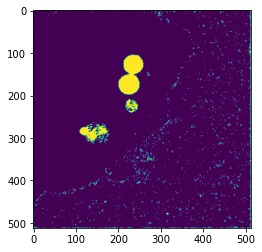

In [17]:
imshow(predictions[20])

In [19]:
A_test_pred = data.Collection.from_list(predictions, X_test_ids) 

In [20]:
M.register(A_test_pred, 'A_test_pred')

In [21]:
# test: check if we can find A_test_pred data in A_test
list(A_test_pred.data.keys())[13]

'f268ce7d-c886-4f75-ae14-4b11df466c86'

In [22]:
M.find(list(A_test_pred.data.keys())[13], show_names=True)

{'A_test': <data.collection.Collection at 0x7f9a11c1b5b0>,
 'A_test_pred': <data.collection.Collection at 0x7f8fc825d130>}

In [23]:
B = data.Collection.from_list(B_)

In [24]:
M.register(B, 'B')

In [25]:
M.names

{'9b40feb6-d801-455d-9844-ce7699e8f4fd': 'A_train',
 'b2a16a66-060e-408a-8e17-506238300389': 'A_val',
 '176fcc4c-f45b-487e-a7ac-62010272d206': 'A_test',
 'b13780c8-e9b9-47bb-84ad-d91ce9155211': 'A_test_pred',
 '2834b7d4-9f72-4584-aedd-f866777290e3': 'B'}

In [26]:
M.save(os.path.join(workingdir, 'M_step1.pickle'))